# (AdaViT) ADAPTIVE VISION TRANSFORMERS

### SAPIENZA UNIVESITY of ROME (DEPARTMENT OF COMPUTER, CONTROL AND MANAGEMENT ENGINEEERING)

### COURSE IN ARTIFICIAL INTELLIGENCE AND ROBOTICS (ACADEMIC YEAR 2023/2024)

### AUTHOR:  **ALESSIO BORGI**


In [34]:
#!kaggle datasets download -d alessioborgi/pico-imagenet-10
#!unzip -q pico-imagenet-10.zip
#!mv "pico-imagenet" dataset


#!kaggle datasets download -d alessioborgi/nano-imagenet-30
#!unzip -q nano-imagenet-30.zip
#!mv "nano-imagenet" dataset


#!kaggle datasets download -d alessioborgi/tiny-imagenet-200
# !unzip -q tiny-imagenet-200.zip
# !mv "tiny-imagenet-200" dataset

### 0: IMPORTING LIBRARIES \& SETTINGS


In [35]:

# Importing PyTorch-related Libraries.
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts
from torchmetrics.classification import Accuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Importing PyTorch Lightning-Related Libraries.
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint

# Importing General Libraries.
import os
import csv
import PIL
import time
import math
import glob
import random
import numpy as np
from PIL import Image
import seaborn as sns
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import OrderedDict

# Importing from Other Files.
from Train_Val_Test_Classes import CustomTrainingTinyImagenet, CustomValidationTinyImagenet, CustomTestTinyImagenet
from Transformations import ViT_Transformations
from Multi_Head_Self_Attention import MHSA
from Positional_Embeddings import get_positional_embeddings_RoPE, get_positional_embeddings_SPE, get_positional_embeddings_BERT
from Gumbel_Noise import add_gumbel_noise
from utils import set_device, seed_everything
from Patchifying import make_matches_from_image

### 1: DATAMODULE

In [25]:

class ViT_DataModule(pl.LightningDataModule):

    def __init__(self, train_data_dir, val_data_dir, test_data_dir, batch_size, num_workers=4):
        """
        Custom data module for AViT model training and validation.

        Args:
        - train_data_dir (str): Directory path for the training dataset.
        - val_data_dir (str): Directory path for the validation dataset.
        - batch_size (int): Batch size for training and validation DataLoader.
        - num_workers (int, optional): Number of workers for DataLoader (default is 4).
        """
        super(ViT_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir
        self.test_data_dir = test_data_dir
        self.batch_size = batch_size
        self.batch_size_test = 5
        self.num_workers = num_workers

        # Use AdaViT transformations for data augmentation
        self.transform = ViT_Transformations()

    def setup(self, stage=None):
        """
        Method to load and configure datasets for Training and Validation.

        Args:
        - stage (str, optional): 'fit' for Training and 'test' for Validation (default is None).
        """
        # Load Train dataset using CustomTrainingTinyImagenet with the new directory structure.
        self.train_dataset = CustomTrainingTinyImagenet(self.train_data_dir, transform=self.transform)

        # Load Validation dataset.
        self.val_dataset = CustomValidationTinyImagenet(self.val_data_dir, transform=self.transform)

        # Load Test dataset.
        self.test_dataset = CustomTestTinyImagenet(self.test_data_dir, transform=self.transform)

    def train_dataloader(self):
        """
        Method to return the DataLoader for the Training Dataset.

        Returns:
        - train_dataloader (DataLoader): DataLoader for Training.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        """
        Method to return the DataLoader for the Validation Dataset.

        Returns:
        - val_dataloader (DataLoader): DataLoader for Validation.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        """
        Method to return the DataLoader for the Test Dataset.

        Returns:
        - test_dataloader (DataLoader): DataLoader for Test Set.
        """
        return DataLoader(self.test_dataset, batch_size=self.batch_size_test, num_workers=self.num_workers)

### 2: VIT-BLOCK 

In [26]:
class ViT_Block_Layer_Norm(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=10):
        super(ViT_Block_Layer_Norm, self).__init__()
        
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )
        
        # Initialize weights.
        self.initialize_weights_block()

    def forward(self, x):
        
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
    
    def initialize_weights_block(self):
        
        # Initialize weights for linear layers in mlp.
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

### 3: VIT DEFINITION

In [27]:

class Vision_Transformer(nn.Module):

    def __init__(self, chw, batch_size, n_patches, n_blocks, hidden_d, n_heads, out_d, lr, nepochs, warmup_epochs, wd, temp, cmlp_ratio, vmlp_ratio):
        """
        Initialize the Vision_Transformer model.

        Parameters:
        - input_d (int): Dimension of the input.
        - n_patches (int): Number of patches.
        - n_blocks (int): Number of transformer blocks.
        - hidden_d (int): Dimension of the hidden layer.
        - n_heads (int): Number of attention heads.
        - out_d (int): Output dimension.
        - lr (float): Learning rate.
        - wd (float): Weight decay.
        - temp (float): Temperature scaling.
        - cmlp_ratio (int): Ratio for the classification MLP.
        - vmlp_ratio (int): Ratio for the ViT MLP.
        """

        # Super Constructor.
        super(Vision_Transformer, self).__init__()

        # Model Attributes.
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.class_mlp_ratio = cmlp_ratio
        self.vit_mlp_ratio = vmlp_ratio

    
        # Input and Patches Sizes.
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear Mapper.
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable Classification Token.
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional Embedding.
        #self.register_buffer('positional_embeddings', get_positional_embeddings_SPE(n_patches ** 2 + 1, self.hidden_d), persistent=False)
        self.register_buffer('positional_embeddings', get_positional_embeddings_RoPE(n_patches ** 2 + 1, self.hidden_d), persistent=False)

        # 4) Transformer Encoder Blocks.
        # Select one of the following blocks.
        # 4.1) Transformer Block with Layer Normalization.
        self.blocks = nn.ModuleList([ViT_Block_Layer_Norm(self.hidden_d, self.n_heads,self.vit_mlp_ratio) for _ in range(self.n_blocks)])

        # 5) Classification MLP.
        self.mlp = nn.Sequential(
          nn.Linear(self.hidden_d, class_mlp_ratio * hidden_d),
          nn.GELU(),
          nn.Linear(class_mlp_ratio * hidden_d, out_d),
        )

        # Initialize weights.
        self.initialize_weights()

    def forward(self, images):
        """
        Forward pass of the Vision_Transformer model.

        Parameters:
        - images (torch.Tensor): Input images tensor.

        Returns:
        torch.Tensor: Output tensor.
        """

        # Dividing Images into Patches.
        n, c, h, w = images.shape
        patches = make_matches_from_image(images, self.n_patches).to(self.positional_embeddings.device)

        # Running Linear Layer Tokenization.
        # Map the Vector corresponding to each patch to the Hidden Size Dimension.
        tokens = self.linear_mapper(patches)

        # Adding Classification Token to the Tokens.
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1).to("cuda")

        # Adding Positional Embedding.
        out = tokens + self.positional_embeddings.repeat(n, 1, 1).to("cuda")

        # Transformer Blocks.
        for block in self.blocks:
            
            out = block(out)
            
        out = out[:, 0]
        
        return self.mlp(out)


    def initialize_weights(self):
        """
        Initialize weights for linear layers, embeddings, etc.
        """

        # Initialize Weights for Linear Layers, Embeddings, etc.
        nn.init.xavier_uniform_(self.linear_mapper.weight)
        nn.init.normal_(self.class_token.data)

        # Initialize Weights for Classification MLP.
        nn.init.xavier_uniform_(self.mlp[0].weight)


In [28]:

class ViT(Vision_Transformer, pl.LightningModule):

    def __init__(self, input_d, batch_size, n_patches, n_blocks, hidden_d, n_heads, out_d, lr, nepochs, warmup_epochs, wd, temp, cmlp_ratio, vmlp_ratio):
        """
        Initialize the ViT, a LightningModule using Vision_Transformer as a base.

        Parameters:
        - input_d (int): Dimension of the input.
        - n_patches (int): Number of patches.
        - n_blocks (int): Number of transformer blocks.
        - hidden_d (int): Dimension of the hidden layer.
        - n_heads (int): Number of attention heads.
        - out_d (int): Output dimension.
        - lr (float): Learning rate.
        - wd (float): Weight decay.
        - temp (float): Temperature scaling.
        - cmlp_ratio (int): Ratio for the classification MLP.
        - vmlp_ratio (int): Ratio for the ViT MLP.
        """
        super(ViT, self).__init__(input_d, batch_size, n_patches, n_blocks, hidden_d, n_heads, out_d, lr, nepochs, warmup_epochs, wd, temp, cmlp_ratio, vmlp_ratio)
        # Optimizer hyperparams.
        self.learning_rate = lr
        self.nepochs = nepochs
        self.weight_decay = wd
        self.warmup_epochs = warmup_epochs
        self.batch_size = batch_size

        # Definition of the Cross Entropy Loss.
        self.loss = CrossEntropyLoss()
        self.temperature = temp

        # Definition of Accuracies, F1Score, Precision, and Recall Metrics.
        self.acc_top1 = Accuracy(task="multiclass", num_classes=out_d)
        self.acc_top3 = Accuracy(task="multiclass", num_classes=out_d, top_k=3)
        self.acc_top5 = Accuracy(task="multiclass", num_classes=out_d, top_k=5)
        self.acc_top10 = Accuracy(task="multiclass", num_classes=out_d, top_k=10)
        self.f1score = MulticlassF1Score(num_classes=out_d, average='macro')
        self.precision = MulticlassPrecision(num_classes=out_d, average='macro')
        self.recall = MulticlassRecall(num_classes=out_d, average='macro')

        # Definition of lists to be used in the "on_ ... _epoch_end" functions.
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        #list of train and validation per epochs performance
        self.train_loss=[]
        self.train_acc=[]
        self.val_loss=[]
        self.val_acc1=[]
        self.val_acc3=[]
        self.val_acc5=[]
        self.val_acc10=[]
        self.perc=[]
        self.var=[]

    def _step(self, batch):
        """
        Common computation of the metrics among Training, Validation, and Test Set.

        Parameters:
        - batch (tuple): Input batch tuple.

        Returns:
        tuple: Tuple containing loss and various metrics.
        """
        x, y = batch
        # Compute the Logits.
        preds = self(x)
        # Scale the logits using a Temperature Scaling and add Gumbel Noise, s.t. you obtain Gumbel Softmax then.
        preds_scaled = add_gumbel_noise(preds) / self.temperature
        loss = self.loss(preds_scaled, y) 
        acc1 = self.acc_top1(preds, y)
        acc3 = self.acc_top3(preds, y)
        acc5 = self.acc_top5(preds, y)
        acc10 = self.acc_top10(preds, y)
        f1score = self.f1score(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        return loss, acc1, acc3, acc5, acc10, f1score, precision, recall

    def training_step(self, batch, batch_idx):
        """
        Training step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        torch.Tensor: Training loss.
        """
        # Compute the Training Loss and Accuracy.
        loss, acc, _, _, _, _, _, _ = self._step(batch)

        # Create a Dictionary to represent the output of the Training step.
        training_step_output = {
            "train_loss": loss.item(),
            "train_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.training_step_outputs.append(training_step_output)

        # Perform logging.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_train_epoch_end(self):
        """
        Method called at the end of the training epoch.
        Returns:
        None
        """
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["train_loss"] for item in self.training_step_outputs]).mean().to("cuda")
        acc_tot = torch.tensor([item["train_acc"] for item in self.training_step_outputs]).mean().to("cuda")

        # Log the mean values.
        self.log("train_loss", loss_tot)
        self.log("train_acc", acc_tot)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Training Loss -> {loss_tot}'
        message_accuracy = f'      Training Accuracy -> {acc_tot}'
        print(message_loss + message_accuracy)

        # Clear the list to free memory.
        self.training_step_outputs.clear()

        #updating training performance lists
        self.train_loss.append(loss_tot.item())
        self.train_acc.append(acc_tot.item())


        #updating csv logs file
        new_row=str(self.train_loss[-1])+","+str(self.train_acc[-1])+","+str(self.val_loss[-1])+","+str(self.val_acc1[-1])+","+str(self.val_acc3[-1])+","+str(self.val_acc5[-1])+","+str(self.val_acc10[-1])
        with open("./results/logs.csv",'a',newline='') as file:
            #writing row
            file.write(new_row+"\n")

    def validation_step(self, batch, batch_idx):
        """
        Validation step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        None
        """
        # Compute the Validation Loss and Accuracy.
        loss, acc1, acc3, acc5, acc10, _, _, _ = self._step(batch)

        # Create a Dictionary to represent the output of the validation step.
        validation_step_output = {
            "val_loss": loss.item(),
            "val_acc": acc1.item(),
            "val_acc_3": acc3.item(),
            "val_acc_5": acc5.item(),
            "val_acc_10": acc10.item(),
        }

        # Append the dictionary to the list.
        self.validation_step_outputs.append(validation_step_output)

        # Perform logging.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc1, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_3", acc3, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_5", acc5, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_10", acc10, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        """
        Method called at the end of the validation epoch.

        Returns:
        None
        """
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["val_loss"] for item in self.validation_step_outputs]).mean().to("cuda")
        acc_tot = torch.tensor([item["val_acc"] for item in self.validation_step_outputs]).mean().to("cuda")
        acc_tot_3 = torch.tensor([item["val_acc_3"] for item in self.validation_step_outputs]).mean().to("cuda")
        acc_tot_5 = torch.tensor([item["val_acc_5"] for item in self.validation_step_outputs]).mean().to("cuda")
        acc_tot_10 = torch.tensor([item["val_acc_10"] for item in self.validation_step_outputs]).mean().to("cuda")

        # Log the mean values.
        self.log("val_loss", loss_tot)
        self.log("val_acc", acc_tot)
        self.log("val_acc_3", acc_tot_3)
        self.log("val_acc_5", acc_tot_5)
        self.log("val_acc_10", acc_tot_10)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Validation Loss -> {loss_tot}'
        message_accuracy = f'      Validation Accuracy -> {acc_tot}'
        message_accuracy_3 = f'      Validation Accuracy Top-3 -> {acc_tot_3}'
        message_accuracy_5 = f'      Validation Accuracy Top-5-> {acc_tot_5}'
        message_accuracy_10 = f'      Validation Accuracy Top-10-> {acc_tot_10}'
        print(message_loss + message_accuracy + message_accuracy_3 + message_accuracy_5 + message_accuracy_10)

        # Clear the list to free memory.
        self.validation_step_outputs.clear()

        #updating validation performance lists
        self.val_loss.append(loss_tot.item())
        self.val_acc1.append(acc_tot.item())
        self.val_acc3.append(acc_tot_3.item())
        self.val_acc5.append(acc_tot_5.item())
        self.val_acc10.append(acc_tot_10.item())

    def test_step(self, batch, batch_idx):
        """
        Test step function.

        Parameters:
        - batch (tuple): Input batch tuple.
        - batch_idx (int): Batch index.

        Returns:
        torch.Tensor: Model predictions.
        """
        x = batch
        # Compute the Logits.
        preds = self(x)
        print("The prediction is: ", preds)
        return preds

    def on_test_epoch_end(self):
        """
        Method called at the end of the test epoch.

        Returns:
        None
        """
        print("Test Epoch Complete.")

    def predict(self, input_image):
        """
        Method called at Inference Time.

        Returns:
        predicted_labels: prediction over the labels.
        """

        with torch.no_grad():

            preds = self(input_image)

            # Scale the logits using a Temperature Scaling.
            preds_scaled = F.log_softmax(preds / self.temperature, dim=1)

            # Get the predicted class labels.
            predicted_labels = torch.argmax(preds_scaled, dim=1).cpu().numpy()

            return predicted_labels

    def configure_optimizers(self):
        """
        Configure the optimizer.

        Returns:
        torch.optim.Optimizer: The optimizer.
        """
        # Configure the Adam Optimizer.
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001)
        #scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001)
        #optimizer, scheduler = get_optimizer_scheduler(
        #                                               model,
        #                                               lr=self.learning_rate,
        #                                               warmup_epochs=self.warmup_epochs,
        #                                               num_epochs=self.nepochs,
        #                                               weight_decay=self.weight_decay,
        #                                               batch_size=self.batch_size
        #                                               )

        #return optimizer
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}


### 4: CALLBACK DEFINITION

In [29]:
# Checkpoint CallBack Definition.
my_checkpoint_call = ModelCheckpoint(
    dirpath="./checkpoints/",
    filename="Best_Model",
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    save_last=True
)

# Learning Rate CallBack Definition.
my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")

# Early Stopping CallBack Definition.
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=50, mode="min", min_delta=0.001)

# Progress Bar CallBack Definition.
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)

# TensorBoardLogger CallBack Definition.
#tb_logger = TensorBoardLogger(save_dir="./results/logs/", name="ViT")

# CSV CallBack Definition.
csv_logger = CSVLogger("./results/logs/", name="ViT")


### 5: MODEL HYPERPAMETERS \& MODEL INSTANTIATION

In [30]:

# Instantiate the Adaptive Vision Transformer Model.
# Model Hyperparameters-
blocks=12
heads=3
classes=10
hidden_dim=192
batch=64

learning_rate=1.5e-3
weight_decay=1.5e-4
temperature=0.5
class_mlp_ratio=4
vit_mlp_ratio=4
input_size=(3,224, 224)
patches=14

number_epochs = 200
warmup_epochs = 5




# Halting Hyperparameters.
gamma = 5
beta = -10
alpha_ponder = 5e-4
alpha_distribution = 0.1
epsilon = 0.01
expected_stop_depth=2
b_laplace=2 #Set it to "None" if not using laplace_distribution

model = ViT(input_d = input_size,
            batch_size=batch,
            n_patches = patches,
            n_blocks = blocks,
            hidden_d = hidden_dim,
            n_heads = heads,
            out_d = classes,
            lr = learning_rate,
            nepochs = number_epochs,
            warmup_epochs = warmup_epochs,
            wd = weight_decay,
            temp = temperature,
            cmlp_ratio = class_mlp_ratio,
            vmlp_ratio = vit_mlp_ratio
        )

data_module = ViT_DataModule(
    train_data_dir="./dataset/pico-imagenet-10/train/",
    val_data_dir="./dataset/pico-imagenet-10/val/images/",
    test_data_dir="./dataset/pico-imagenet-10/test/images/",
    batch_size=batch
)

# Setup the Dataloaders.
data_module.setup()

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=number_epochs,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else 0,
    log_every_n_steps=1,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
halting_row=f"Halting Hyperparameters: gamma={gamma},beta={beta},alpha_ponder={alpha_ponder},alpha_distribution={alpha_distribution},epsilon={epsilon},expected_stop_depth={expected_stop_depth}"
if b_laplace is not None:
    halting_row +=f",b_laplace={b_laplace}"

with open("./results/logs.csv", 'w') as file:
    #writing header
    perf_header="Training Loss"+","+"Training Accuracy"+","+"Validation Loss"+","+"Validation Top-1 Accuracy"+","+"Validation Top-3 Accuracy"+","+"Validation Top-5 Accuracy"+","+"Validation Top-10 Accuracy"
    halt_header=''
    for i in range(2*blocks):
        if i<blocks:
            string=f"Percentage halted tokens layer_{i}"
        else:
            string=f"Variance halted tokens layer_{i-blocks}"
        halt_header+=","+string
    file.write(f"Model Hypeparameters: input_size={input_size},n_patches={patches},n_blocks={blocks},n_heads={heads},hidden_d={hidden_dim},output_size={classes},batch_size={batch},learning_rate={learning_rate},weight_decay={weight_decay},temp={temperature},class_mlp_ratio={class_mlp_ratio},vit_mlp_ratio={vit_mlp_ratio}\n")
    file.write(halting_row+"\n")
    file.write(perf_header+halt_header+"\n")

### 6: MODEL TRAINING

In [32]:
# Train the model
trainer.fit(model.to("cuda"), data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                | Params
-------------------------------------------------------
0  | linear_mapper | Linear              | 147 K 
1  | blocks        | ModuleList          | 4.0 M 
2  | mlp           | Sequential          | 155 K 
3  | loss          | CrossEntropyLoss    | 0     
4  | acc_top1      | MulticlassAccuracy  | 0     
5  | acc_top3      | MulticlassAccuracy  | 0     
6  | acc_top5      | MulticlassAccuracy  | 0     
7  | acc_top10     | MulticlassAccuracy  | 0     
8  | f1score       | MulticlassF1Score   | 0     
9  | precision     | MulticlassPrecision | 0     
10 | recall        | MulticlassRecall    | 0     
   | other params  | n/a                 | 192   
-------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.251    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 5.293000221252441      Validation Accuracy -> 0.1484375      Validation Accuracy Top-3 -> 0.4453125      Validation Accuracy Top-5-> 0.5859375      Validation Accuracy Top-10-> 1.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 4.957973957061768      Validation Accuracy -> 0.18960335850715637      Validation Accuracy Top-3 -> 0.530348539352417      Validation Accuracy Top-5-> 0.7253605723381042      Validation Accuracy Top-10-> 1.0
Epoch 0 Training Loss -> 5.486188888549805      Training Accuracy -> 0.17761075496673584


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation Loss -> 4.4162139892578125      Validation Accuracy -> 0.27809494733810425      Validation Accuracy Top-3 -> 0.616286039352417      Validation Accuracy Top-5-> 0.7752403616905212      Validation Accuracy Top-10-> 1.0
Epoch 1 Training Loss -> 4.5047173500061035      Training Accuracy -> 0.2604826092720032


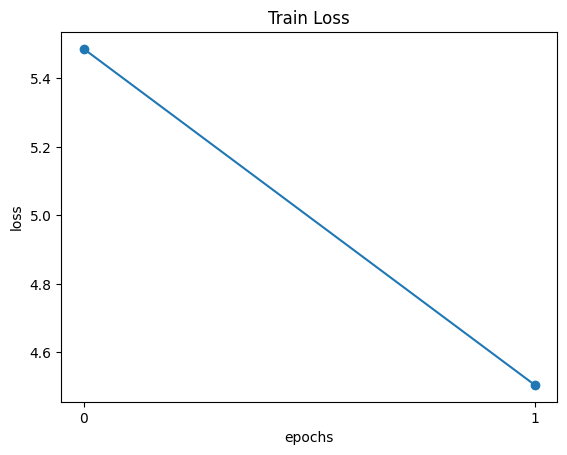

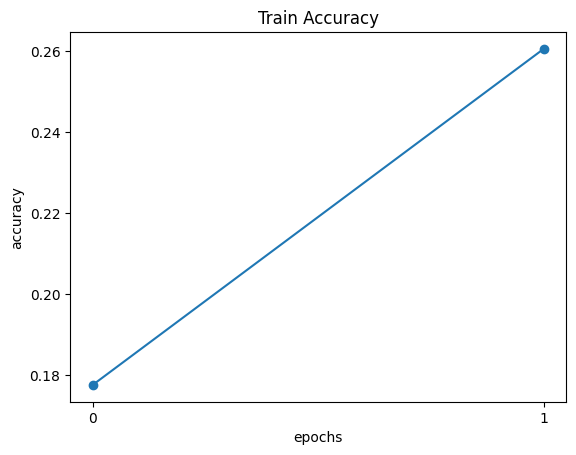

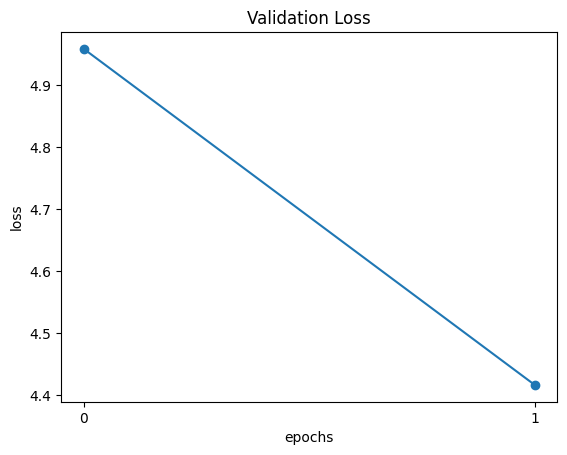

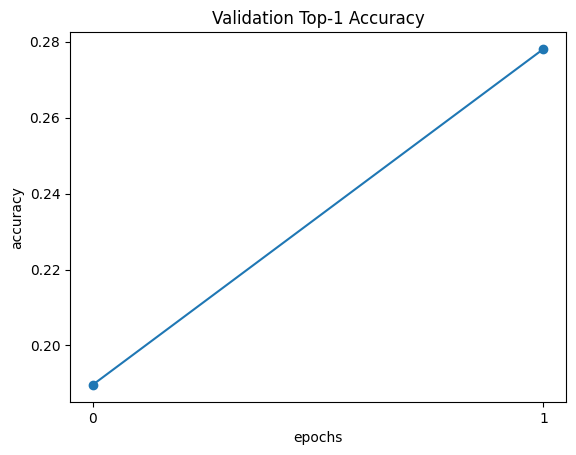

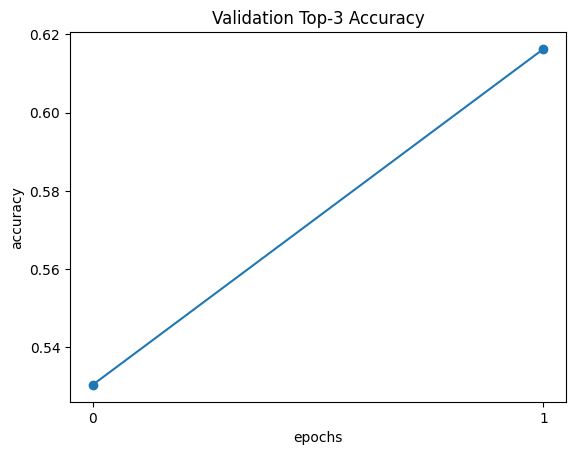

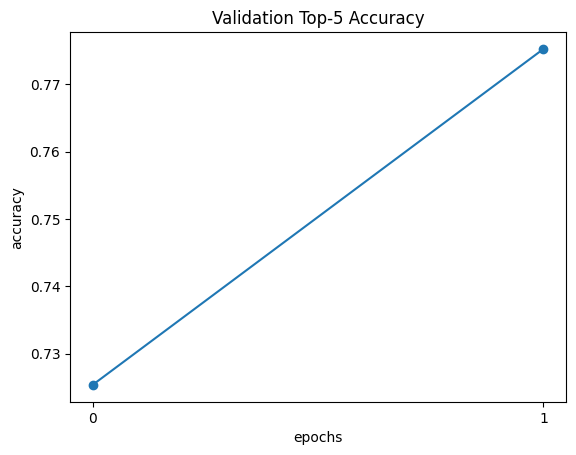

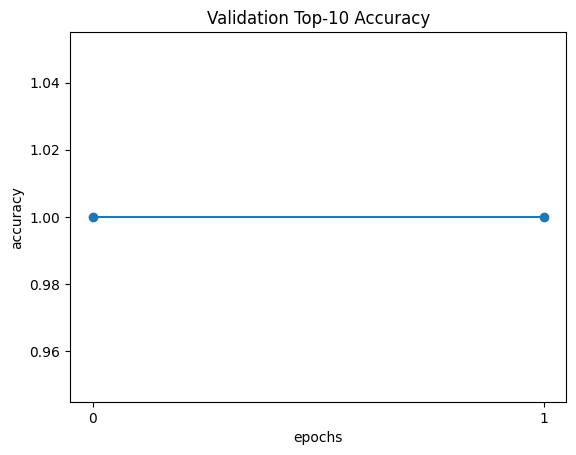

IndexError: list index out of range

In [33]:
save_path="./results/"
# Plotting Performace metrics
def plotter(data, xlabel, ylabel, title, is_halting):
    if is_halting:
        plt.style.use('bmh')
    plt.xticks([i for i in range(len(data))])
    plt.plot(data,marker="o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    name=title.replace(" ","_")
    plt.savefig(save_path+f"{name}.png")
    plt.show()

# Removing first element.
val_loss=[x for x in model.val_loss[1:]]
val_acc1=[x for x in model.val_acc1[1:]]
val_acc3=[x for x in model.val_acc3[1:]]
val_acc5=[x for x in model.val_acc5[1:]]
val_acc10=[x for x in model.val_acc10[1:]]

# print("Performance lists: ")
# print(model.train_loss)
# print(model.train_acc)
# print(val_loss)
# print(val_acc1)
# print(val_acc3)
# print(val_acc5)
# print(val_acc10)
# print(model.perc)
# print(model.var)

# Plotting.
plotter(model.train_loss,"epochs","loss","Train Loss",False)
plotter(model.train_acc,"epochs","accuracy","Train Accuracy",False)
plotter(val_loss,"epochs","loss","Validation Loss",False)
plotter(val_acc1,"epochs","accuracy","Validation Top-1 Accuracy",False)
plotter(val_acc3,"epochs","accuracy","Validation Top-3 Accuracy",False)
plotter(val_acc5,"epochs","accuracy","Validation Top-5 Accuracy",False)
plotter(val_acc10,"epochs","accuracy","Validation Top-10 Accuracy",False)
plotter(model.perc[-1],"layers","percentage","Percentage Halted Tokens",True)
plotter(model.var[-1],"layers","variance","Variance Halted Tokens",True)

### 7: MODEL SAVING

In [ ]:
# Get the path of the best Model.
best_model_path = my_checkpoint_call.best_model_path

# Load the best model from the Checkpoint.
best_model = ViT.load_from_checkpoint(
                   checkpoint_path=best_model_path,
                   input_d = input_size,
                   batch_size=batch,
                   n_patches = patches,
                   n_blocks = blocks,
                   hidden_d = hidden_dim,
                   n_heads = heads,
                   out_d = classes,
                   lr = learning_rate,
                   nepochs = number_epochs,
                   warmup_epochs = warmup_epochs,
                   wd = weight_decay,
                   temp = temperature,
                   cmlp_ratio = class_mlp_ratio,
                   vmlp_ratio = vit_mlp_ratio,
                   )

# Access the Best Model's Accuracy.
best_model_accuracy = trainer.checkpoint_callback.best_model_score.item()
print(f"Best Model Accuracy: {best_model_accuracy}")

In [ ]:
# Save it as a pth file.
# Specify the path where you want to save the model.
model_path = f"./models/best_model_acc_{best_model_accuracy:.5f}.pth"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), model_path)

# Save it as a CheckPoint (Specific of PyTorch Lightning = Model State Dictionary + Training State + Optimizer State).
# Specify the path where you want to save the model checkpoint.
ckpt_path = f"./models/best_model_acc_{best_model_accuracy:.5f}.ckpt"

# Save the model's state dict to the specified file.
torch.save(best_model.state_dict(), ckpt_path)